In [13]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
df = pd.read_csv(r'C:\Users\yusuf\ML_projects\datasets\spamDS\spam.csv', encoding='ISO-8859-1')

In [3]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
df = df.drop(df.columns[2:], axis=1)
df['v1'] = (df['v1'] == 'spam').astype(int)
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
#cleaning text data
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['v2'] = df['v2'].apply(clean_text)

In [6]:
#extracting features from text
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['v2'])  # Convert text to numerical features
y = df['v1']  # Target labels

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (4457, 8672), Validation: (557, 8672), Test: (558, 8672)


In [8]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model = log_model.fit(X_train, y_train)

In [9]:
y_pred = log_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       483
           1       1.00      0.76      0.86        75

    accuracy                           0.97       558
   macro avg       0.98      0.88      0.92       558
weighted avg       0.97      0.97      0.97       558



In [10]:
#1st solution for imbalanced data: adjusting class weights
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [11]:
y_pred = log_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       483
           1       1.00      0.76      0.86        75

    accuracy                           0.97       558
   macro avg       0.98      0.88      0.92       558
weighted avg       0.97      0.97      0.97       558



In [12]:
#still imbalanced so we can find another solutions like oversampling
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Retrain with resampled data
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

# Recheck classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       483
           1       0.96      0.88      0.92        75

    accuracy                           0.98       558
   macro avg       0.97      0.94      0.95       558
weighted avg       0.98      0.98      0.98       558



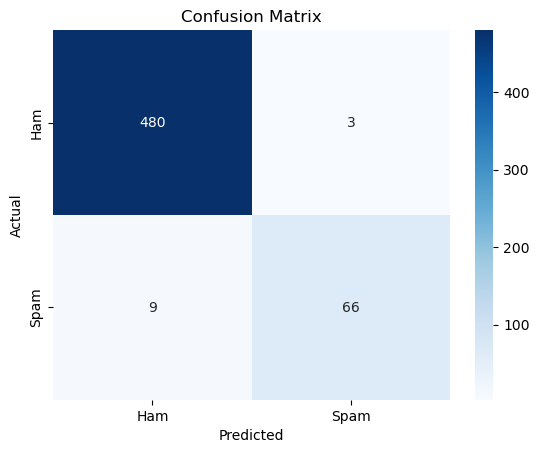

In [14]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [15]:
#Lowering the Decision Threshold (for even higher spam recall):
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.4).astype(int)  # Adjust threshold from 0.5 to 0.4
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       483
           1       0.93      0.95      0.94        75

    accuracy                           0.98       558
   macro avg       0.96      0.97      0.97       558
weighted avg       0.98      0.98      0.98       558



In [17]:
#saving the model
import joblib

joblib.dump(model, "spam_classifier.pkl")  # Save model
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")  # Save TF-IDF

['tfidf_vectorizer.pkl']

In [18]:
#testing our model on realworld messages
sample_texts = ["You won a free trip to Bali! Click now!", 
                "Hey, are we meeting tomorrow?", 
                "Your bank account has been compromised. Reply ASAP!"]

# Convert text to TF-IDF
sample_features = vectorizer.transform(sample_texts)

# Predict
sample_preds = model.predict(sample_features)

# Print results
for text, pred in zip(sample_texts, sample_preds):
    print(f"Message: {text} → {'Spam' if pred == 1 else 'Ham'}")


Message: You won a free trip to Bali! Click now! → Spam
Message: Hey, are we meeting tomorrow? → Ham
Message: Your bank account has been compromised. Reply ASAP! → Spam
